# **Analysing Aerosol Dynamics in Doha and Beijing using Aerosol Extinction Optical Thickness and Ångström Exponent**

This notebook explores how aerosals behave in two sharply contrasting environments: Doha, Qatar (a desert city frequently affected by coarse-mode dust aerosols) and Beijing, China (a megacity dominated by fine-mode urban pollution). By analyzing hourly data for Aerosol Extinction Optical Thickness, also known as Aerosol Optical Depth (AOD) at 550 nm and the Ångström Exponent (AE), we reveal how aerosol properties vary throughout the day - offering insights into both natural and anthropogenic aerosol regimes.

This notebook and anaylsis has been prepared in collaboration with **[Dr. Yazan J.K. Musleh](https://www.linkedin.com/in/yazanabbadi/)**

In [1]:
from pvradar.sdk import PvradarSite, R, resource_plot, describe, __version__

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize

In [2]:
print(f'You need pvradar.sdk version 2.9.0 or higher. Your version is {__version__}.')

You need pvradar.sdk version 2.9.0 or higher. Your version is 2.9.0.


## Site and time period

We define two locations for the comparison: Doha and Beijing.

In [3]:
doha = PvradarSite(location=(25.276987, 51.520008), interval='2020-01-01..2020-12-31')
beijing = PvradarSite(location=(39.904202, 116.407394), interval='2020-01-01..2020-12-31')

## Download aerosol data for both locations

To analyze how aerosol behavior changes throughout the day in both Doha and Beijing, we retrieve hourly-averaged data for two key aerosol properties: Aerosol Optical Depth (AOD) at 550 nm and the Ångström Exponent (AE). These variables are extracted from the MERRA-2 reanalysis dataset using the resource() method, which allows seamless access to time series from the registered models. The to_freq='h' argument ensures that the data is resampled to hourly resolution, providing the necessary granularity to study diurnal patterns. This step is essential, as aerosols often exhibit strong intra-day variability due to factors such as atmospheric mixing, emissions, and meteorological shifts - phenomena that would be hidden in daily averages.

In [ ]:
aod_doha = doha.resource(R.aerosol_extinction_optical_thickness(datasource='merra2', to_freq='h'), label='AOD Doha')
ae_doha = doha.resource(R.aerosol_angstrom_exponent(datasource='merra2', to_freq='h'), label='AE Doha')

aod_beijing = beijing.resource(R.aerosol_extinction_optical_thickness(datasource='merra2', to_freq='h'), label='AOD Beijing')
ae_beijing = beijing.resource(R.aerosol_angstrom_exponent(datasource='merra2', to_freq='h'), label='AE Beijing')

To see a table of all available data through pvradar go to [Resource DB](https://pvradar.notion.site/1d157af8487c80d68be3ce9473e9bbba?v=1d157af8487c81759b9f000cecd9245f).

In [5]:
describe(aod_doha)

aerosol_extinction_optical_thickness: mean hourly aerosol extinction optical thickness in dimensionless from merra2 labeled "AOD Doha"
8784 data points (2020-01-01 00:00:00+03:00 to 2020-12-31 23:00:00+03:00)

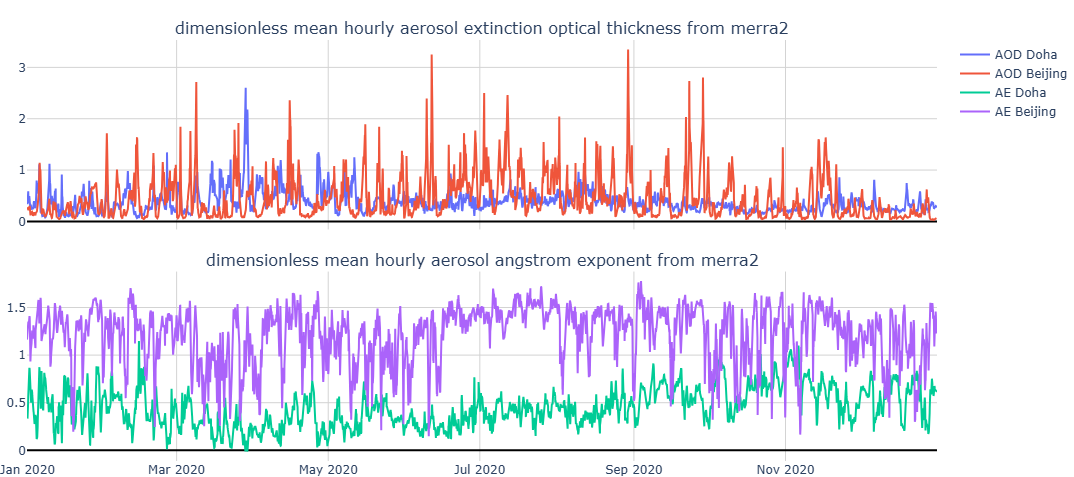

In [6]:
resource_plot(aod_doha, aod_beijing, ae_doha, ae_beijing, group_by='resouce_type')

### Interpreting the Hourly AOD and AE Time Series

This figure shows the hourly evolution of aerosol properties over the full year of 2020 for Doha and Beijing.

In the top panel, the AOD reflects the total column aerosol load. It can be observed that:
- Beijing experiences frequent and sharp peaks in AOD, often exceeding 1.0 and occasionally reaching up to 3. These peaks are more frequent during winter months, which is consistent with stagnant atmospheric conditions, reduced boundary layer heights, and increased anthropogenic emissions from heating and traffic.
- Doha, while generally having lower AOD values, shows distinct peaks during spring and summer (March to August), likely corresponding to regional dust events driven by wind systems such as the Shamal. These dust intrusions are episodic but can significantly elevate AOD for several hours to days.

In the bottom panel, the AE reveals the dominant aerosol particle size:
- Beijing maintains consistently high AE values (>1.2) across most of the year, especially in late winter and early spring, indicative of fine-mode particles from urban pollution, including sulfate, nitrate, and organic aerosols.
- Doha shows persistently low AE values (mostly <0.6), reinforcing the dominance of coarse-mode dust aerosols. Notably, AE values in Doha occasionally drop even further during major dust events, a signature of large particle dominance.


## Visualize diurnal cycles

We compute and plot the average diurnal cycle for both parameters.

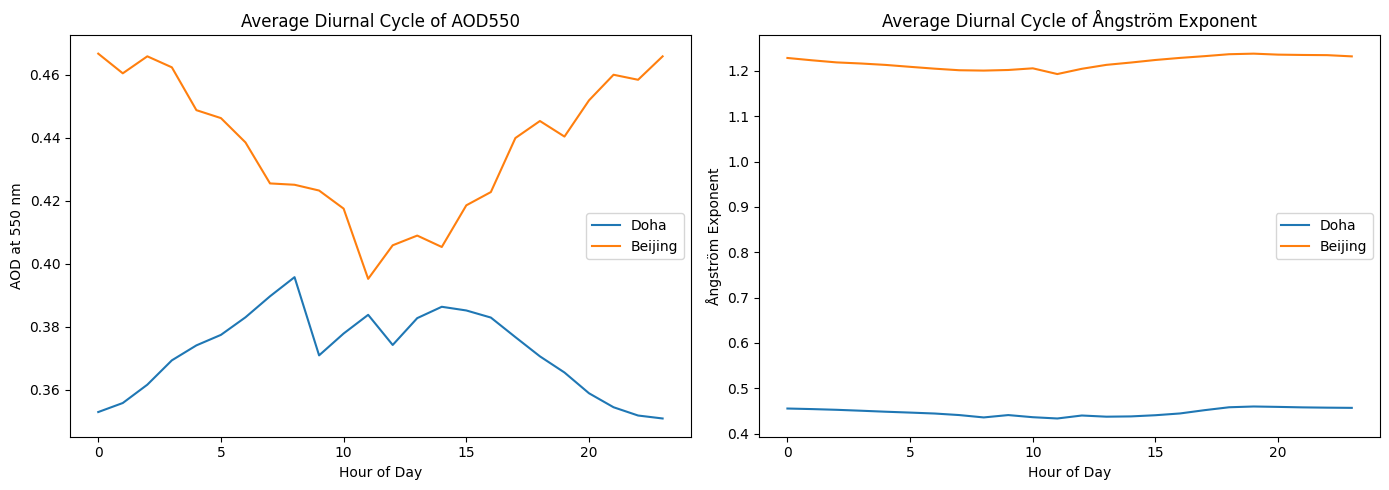

In [7]:
def diurnal_cycle(series):
    return series.groupby(series.index.hour).mean()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# AOD
axs[0].plot(diurnal_cycle(aod_doha), label='Doha')
axs[0].plot(diurnal_cycle(aod_beijing), label='Beijing')
axs[0].set_title('Average Diurnal Cycle of AOD550')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('AOD at 550 nm')
axs[0].legend()

# AE
axs[1].plot(diurnal_cycle(ae_doha), label='Doha')
axs[1].plot(diurnal_cycle(ae_beijing), label='Beijing')
axs[1].set_title('Average Diurnal Cycle of Ångström Exponent')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Ångström Exponent')
axs[1].legend()

plt.tight_layout()
plt.show()


In Doha, AOD exhibits a pronounced midday peak, which aligns with typical dust activity driven by surface heating and convective turbulence around solar noon. The AE in Doha remains consistently low (around 0.4–0.6), confirming that coarse-mode particles (mainly mineral dust) are dominant throughout the day.

In contrast, Beijing shows elevated AOD across the full day with only a modest dip around midday. This pattern suggests persistent fine-mode aerosol presence, likely linked to urban emissions, secondary aerosol formation, and limited vertical mixing. AE values in Beijing are significantly higher (typically above 1.2), which is characteristic of pollution-driven aerosols like sulfates, organics, and combustion byproducts.

These contrasting patterns—midday peaks in Doha versus flatter curves in Beijing, low AE vs high AE—demonstrate how aerosol dynamics differ fundamentally between desert and urban environments.

## AOD vs Ångström Exponent Scatter Plot

This scatter plot helps visually distinguish aerosol types.

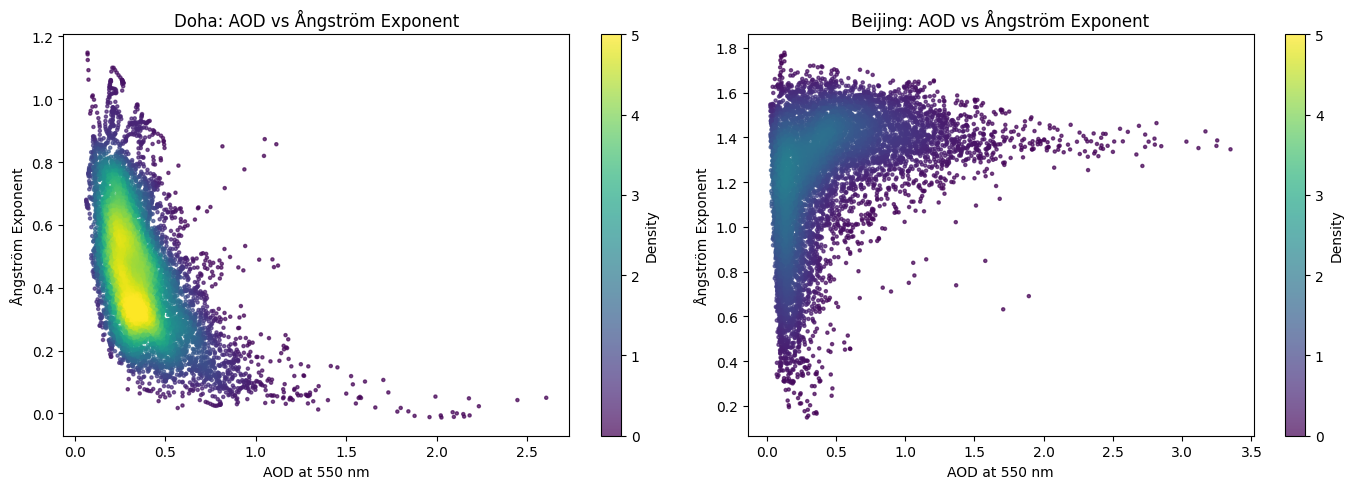

In [ ]:
def compute_density(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    return x, y, z

x_doha, y_doha, z_doha = compute_density(aod_doha.values, ae_doha.values)
x_bj, y_bj, z_bj = compute_density(aod_beijing.values, ae_beijing.values)

z_doha = np.clip(z_doha, 0, 5)
z_bj = np.clip(z_bj, 0, 5)

norm = Normalize(vmin=0, vmax=5)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sc1 = axs[0].scatter(x_doha, y_doha, c=z_doha, cmap='viridis', s=5, alpha=0.7, norm=norm)
axs[0].set_title('Doha: AOD vs Ångström Exponent')
axs[0].set_xlabel('AOD at 550 nm')
axs[0].set_ylabel('Ångström Exponent')
cbar1 = fig.colorbar(sc1, ax=axs[0], ticks=np.arange(0, 6, 1))
cbar1.set_label('Density')

sc2 = axs[1].scatter(x_bj, y_bj, c=z_bj, cmap='viridis', s=5, alpha=0.7, norm=norm)
axs[1].set_title('Beijing: AOD vs Ångström Exponent')
axs[1].set_xlabel('AOD at 550 nm')
axs[1].set_ylabel('Ångström Exponent')
cbar2 = fig.colorbar(sc2, ax=axs[1], ticks=np.arange(0, 6, 1))
cbar2.set_label('Density')

plt.tight_layout()
plt.show()

The scatter plots colored by density illustrate the relationship between AOD and AE, helping to distinguish between aerosol types. In Doha, we observe a dense cluster of points with moderate AOD and low AE (< 0.6), which is characteristic of coarse-mode aerosols such as mineral dust. The AE tends to drop as AOD increases, revealing an inverse relationship typical of dust-dominated regimes. On the other hand,  in Beijing, points are densely packed at low AOD and high AE (> 1.2), which is consistent with fine-mode aerosols like urban pollution and secondary aerosols. Unlike Doha, the AE remains high even when AOD varies, indicating a persistent presence of fine particles. This density-based view helps visualize aerosol regimes: coarse dust in Doha and fine anthropogenic pollution in Beijing.

## Relevance to PV Applications

Understanding aerosol dynamics is critical for solar energy applications. Aerosols directly influence the amount, angular distribution, and spectral composition of solar radiation reaching PV panels. In dust-heavy regions like Doha, coarse particles can cause substantial attenuation and forward scattering, leading to reduced irradiance levels and increased soiling rates on modules. In contrast, urban environments like Beijing are dominated by fine-mode aerosols, which significantly impact the diffuse-to-direct irradiance ratio; a key factor for the performance of PV systems that are sensitive to incident angle, such as bifacial modules and single-axis trackers.

Importantly, aerosols play a central role in estimating clear-sky irradiance, which forms the baseline for a wide range of models used to determine irradiance under all sky conditions. Accurate knowledge of aerosol optical depth and type is therefore essential not only for real-time irradiance assessments but also for robust long-term yield simulations in feasibility and bankability studies. By tracking aerosol properties over time and across diverse locations, this analysis supports improved PV system design, performance forecasting, and investment decision-making.


## Conclusion

- Doha exhibits a pronounced midday peak in AOD, consistent with dust aerosol dynamics.
- Beijing shows elevated AE during morning and evening, indicative of fine-mode urban pollution.
- The scatter plot illustrates different aerosol regimes: coarse-mode dominated in Doha and fine-mode in Beijing.

# 

## **About pvradar.sdk**

### Built to allow you to focus on your research, not fetching data

- The PVRADAR SDK allows accessing data in a single line of code.
- Seamlessly connect to satellite data & meteo stations.
- Automatic unit conversion, time-zone adjustment, and timestamp alignment.

### Embed your model or analysis in a broader context
- You created a new model to estimate module temperature? Calculate the impact on a typical PV power plant.
- Developed a new algorithm to detect snow losses? Run it across 20 years of historical data for multiple sites.
- You have an empirical relation between environmental conditions and degradation? Create a map showing its impact across the country.

### Make your research available to others
By creating a notebook based on pvradar.sdk in addition to your published paper, you allow others to easily repeat, validate, and reuse your work. For any location globally.


👉 **Ready to go further?** [**Contact us to learn how we can help elevate your research!**](https://pvradar.com/contact)